In [2]:
using Reachability, MathematicalSystems, TaylorIntegration
using Plots

In [3]:
@taylorize function doublegyre!(dx, x, params, t)
    local A = 0.1
    dx[1] = -π*A*sin(π*x[1])*cos(π*x[2])
    dx[2] = π*A*cos(π*x[1])*sin(π*x[2])
    return dx
end

In [4]:
𝑆 = BlackBoxContinuousSystem(doublegyre!, 2)
X0 = Hyperrectangle(low=[0.19, 0.89], high=[0.2, 0.9])
X1 = Hyperrectangle(low=[1.8, 0.89], high=[1.81, 0.9])
𝑃0 = InitialValueProblem(𝑆, X0)
𝑃1 = InitialValueProblem(𝑆, X1)

# reach mode
𝑂 = Options(:T=>20.0, :mode=>"reach")
sol0 = solve(𝑃0, 𝑂, op=TMJets(:abs_tol=>1e-18, :orderT=>10, :orderQ=>4, :max_steps=>10_000));
sol1 = solve(𝑃1, 𝑂, op=TMJets(:abs_tol=>1e-18, :orderT=>10, :orderQ=>4, :max_steps=>10_000));

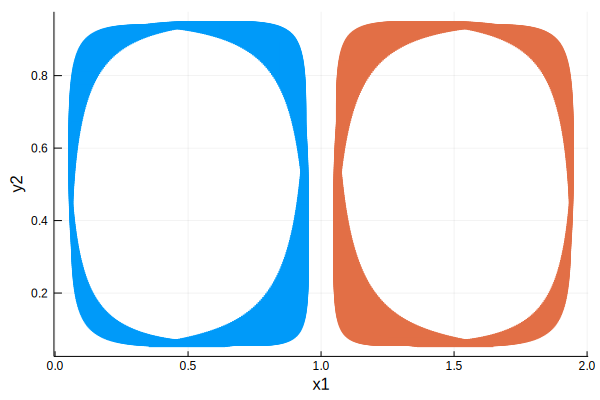

In [5]:
plot(sol0, alpha=1, xlab="x1", ylab="y2")
plot!(sol1, alpha=1, xlab="x1", ylab="y2")

## Usamos TMJets directamente

In [6]:
using TaylorSeries

In [7]:
# include("TMJets/solve.jl")

using Reachability.ReachSets: validated_integ
using TaylorSeries: set_variables
using LazySets.Approximations: box_approximation
using LazySets: center
using IntervalArithmetic: IntervalBox

function solve_TMJets(P, opts)

    # ==================================
    # Initialization
    # ==================================

    # system of ODEs
    f! = P.s.f
    n = statedim(P)

    # initial time and time horizon
    t0 = 0.0
    T = opts[:T]

    # maximum allowed number of steps
    max_steps = opts[:max_steps]

    # unrap algorithm-specific options
    abs_tol, orderQ, orderT = opts[:abs_tol], opts[:orderQ], opts[:orderT]

    # initial sets
    box_x0 = box_approximation(P.x0)
    q0 = center(box_x0)
    δq0 = IntervalBox(low(box_x0)-q0, high(box_x0)-q0)

    # fix the working variables and maximum order in the global
    # parameters struct (_params_TaylorN_)
    set_variables("x", numvars=length(q0), order=2*orderQ)

    # no property (reach mode)
    property = (t, x) -> true

    # =====================
    # Flowpipe computation
    # =====================

    tTM, xTM, vTM = validated_integ(f!, q0, δq0, t0, T, orderQ, orderT, abs_tol,
                                    maxsteps=max_steps, check_property=property)

    return (tTM, xTM, vTM)
end


solve_TMJets (generic function with 1 method)

In [8]:
𝑆 = BlackBoxContinuousSystem(doublegyre!, 2)
X0 = Hyperrectangle(low=[0.19, 0.89], high=[0.2, 0.9])
X1 = Hyperrectangle(low=[1.8, 0.89], high=[1.81, 0.9])
𝑃0 = InitialValueProblem(𝑆, X0)
𝑃1 = InitialValueProblem(𝑆, X1)

InitialValueProblem{BlackBoxContinuousSystem{typeof(doublegyre!)},Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}}(BlackBoxContinuousSystem{typeof(doublegyre!)}(doublegyre!, 2), Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([1.8050000000000002, 0.895], [0.004999999999999893, 0.0050000000000000044]))

In [9]:
opts = Options(:T=>20.0, :abs_tol=>1e-18, :orderT=>10, :orderQ=>4, :max_steps=>10_000);
sol = solve_TMJets(𝑃1, opts);

## Armamos un flowpipe con zonotopes

In [10]:
# extraemos el flowpipe como taylor models
tm = sol[3];
Xk = [tm[:, i] for i in 1:size(tm, 2)];

In [11]:
size(tm, 2)

801

In [12]:
# primer conjunto
Xk[1]

2-element Array{TaylorModels.TaylorModel1{TaylorN{Float64},Float64},1}:
   1.8050000000000002 + 0.004999999999999893 x₁ + [0, 0]
               0.895 + 0.0050000000000000044 x₂ + [0, 0]

In [13]:
using TaylorModels

Los tiempos estan corridos para empezar en 0 en cada tramo.

In [14]:
[domain(Xk[i][1]) for i in 1:10]

10-element Array{IntervalArithmetic.Interval{Float64},1}:
 [0, 0]         
  [0, 0.0273085]
  [0, 0.0272739]
  [0, 0.0272892]
  [0, 0.0273648]
  [0, 0.027517] 
  [0, 0.0277726]
  [0, 0.0281796]
  [0, 0.0288368]
  [0, 0.0299982]

In [15]:
sol[1][1:10]

10-element Array{Float64,1}:
 0.0                
 0.02730843095941959
 0.05458226867513573
 0.08187142153717576
 0.10923620133489044
 0.13675316596585801
 0.1645256791136103 
 0.19270523656071645
 0.22154199084898304
 0.25154014545554104

In [16]:
X = Xk[2]

2-element Array{TaylorModel1{TaylorN{Float64},Float64},1}:
                                           1.8050000000000002 + 0.004999999999999893 x₁ + ( - 0.17090391276536804 + 0.0038197316748540917 x₁ - 0.0009191277183935669 x₂ + 2.1084425119904953e-5 x₁² + 2.0542661676823305e-5 x₁ x₂ + 2.1084425119905892e-5 x₂² - 1.570801689546615e-7 x₁³ + 1.1339283718274979e-7 x₁² x₂ - 4.7124050686400554e-7 x₁ x₂² + 3.77976123942516e-8 x₂³ - 4.3353111449550844e-10 x₁⁴ - 8.447831003985681e-10 x₁³ x₂ - 2.601186686973167e-9 x₁² x₂² - 8.447831003986056e-10 x₁ x₂³ - 4.335311144955471e-10 x₂⁴) t + ( - 0.07293302361341987 + 0.0008249038227460406 x₁ + 3.599100454198661e-5 x₁² - 1.6940658945086007e-21 x₁ x₂ - 3.3881317890172014e-21 x₂² - 1.3569123999082347e-7 x₁³ + 5.293955920339377e-23 x₁ x₂² - 2.9601414735600247e-9 x₁⁴ + 8.271806125530277e-25 x₁² x₂² + 4.1359030627651384e-25 x₁ x₂³ - 2.0679515313825692e-25 x₂⁴) t² + ( - 0.009398619397494066 - 0.0006100730493808136 x₁ - 5.054613123298109e-5 x₂ + 2.41276716351

In [17]:
Δt = domain(X[2])

[0, 0.0273085]

In [18]:
X_Δt = evaluate(X, Δt)

2-element Array{TaylorN{IntervalArithmetic.Interval{Float64}},1}:
  [1.80027, 1.80501] + [0.00499999, 0.00510493] x₁ + [-2.5101e-05, 0] x₂ + [0, 6.03118e-07] x₁² + [0, 5.60988e-07] x₁ x₂ + [0, 5.75807e-07] x₂² + [-4.39081e-09, 0] x₁³ + [0, 3.09924e-09] x₁² x₂ + [-1.28689e-08, 0] x₁ x₂² + [0, 1.03224e-09] x₂³ + [-1.41451e-11, 0] x₁⁴ + [-2.30698e-11, 0] x₁³ x₂ + [-7.10952e-11, 0] x₁² x₂² + [-2.30698e-11, 0] x₁ x₂³ + [-1.18396e-11, 0] x₂⁴ + 𝒪(‖x‖⁵)
   [0.894999, 0.897274] + [0, 2.51024e-05] x₁ + [0.00489568, 0.00500001] x₂ + [-2.80521e-07, 0] x₁² + [-1.15162e-06, 0] x₁ x₂ + [-2.80494e-07, 0] x₂² + [-1.0323e-09, 0] x₁³ + [0, 1.28695e-08] x₁² x₂ + [-3.10075e-09, 0] x₁ x₂² + [0, 4.28962e-09] x₂³ + [0, 5.76799e-12] x₁⁴ + [0, 4.73587e-11] x₁³ x₂ + [0, 3.46512e-11] x₁² x₂² + [0, 4.73983e-11] x₁ x₂³ + [0, 5.76743e-12] x₂⁴ + 𝒪(‖x‖⁵)

In [19]:
X[1].rem

[-1.00737e-21, 1.31338e-21]

In [20]:
X[1]

  1.8050000000000002 + 0.004999999999999893 x₁ + ( - 0.17090391276536804 + 0.0038197316748540917 x₁ - 0.0009191277183935669 x₂ + 2.1084425119904953e-5 x₁² + 2.0542661676823305e-5 x₁ x₂ + 2.1084425119905892e-5 x₂² - 1.570801689546615e-7 x₁³ + 1.1339283718274979e-7 x₁² x₂ - 4.7124050686400554e-7 x₁ x₂² + 3.77976123942516e-8 x₂³ - 4.3353111449550844e-10 x₁⁴ - 8.447831003985681e-10 x₁³ x₂ - 2.601186686973167e-9 x₁² x₂² - 8.447831003986056e-10 x₁ x₂³ - 4.335311144955471e-10 x₂⁴) t + ( - 0.07293302361341987 + 0.0008249038227460406 x₁ + 3.599100454198661e-5 x₁² - 1.6940658945086007e-21 x₁ x₂ - 3.3881317890172014e-21 x₂² - 1.3569123999082347e-7 x₁³ + 5.293955920339377e-23 x₁ x₂² - 2.9601414735600247e-9 x₁⁴ + 8.271806125530277e-25 x₁² x₂² + 4.1359030627651384e-25 x₁ x₂³ - 2.0679515313825692e-25 x₂⁴) t² + ( - 0.009398619397494066 - 0.0006100730493808136 x₁ - 5.054613123298109e-5 x₂ + 2.412767163511709e-5 x₁² - 3.280995975209881e-6 x₁ x₂ + 1.1595081921208908e-6 x₂² + 1.2378732714435788e-7 x₁³ + 1

In [21]:
m = 2
X̂ = [TaylorModelN(X_Δt[k], X[k].rem, zeroBox(m), symBox(m)) for k in 1:m]

UndefVarError: UndefVarError: zeroBox not defined

In [22]:
plot(sol[2][2]) # caja para el segundo elemento
plot!(overapproximate(fp_rpa.(X̂), Zonotope))

UndefVarError: UndefVarError: X̂ not defined

In [23]:
const IA = IntervalArithmetic
const zeroI = IA.Interval(0.0) # [0.0, 0.0]
const oneI = IA.Interval(1.0) # [1.0, 1.0]
const symI = IA.Interval(-1.0, 1.0)
zeroBox(m) = IntervalBox(zeroI, m)
symBox(m) = IntervalBox(symI, m)

# m is the dimension in space coordinates
function to_zonotope(flowpipe, m; Nmax=size(flowpipe, 2))

    res = Vector{Zonotope{Float64}}(undef, Nmax)

    @inbounds for i in 1:Nmax
        X = flowpipe[:, i] # pick the i-th Taylor model
        Δt = domain(X[1]) # pick the time domain of the given TM (same in all dimensions)
        X_Δt = evaluate(X, Δt) # evaluate the Taylor model in time, the coefficents are now intervals
        # and t disappears
         
        # builds the associated taylor model for each coordinate
        X̂ = [TaylorModelN(X_Δt[k], X[k].rem, zeroBox(m), symBox(m)) for k in 1:m]

        # floating point rigorous polynomial approximation
        fX̂ = fp_rpa.(X̂)

        # LazySets can overapproximate a Taylor model with a Zonotope
        res[i] = overapproximate(fX̂, Zonotope)
    end
    return res
end

to_zonotope (generic function with 1 method)

In [24]:
z = to_zonotope(sol[3], 2);

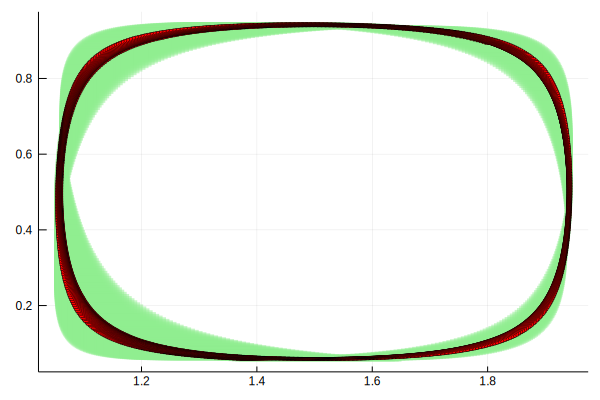

In [25]:
plot(sol[2][:], color=:lightgreen, lw=0.0, label="", alpha=.1)
plot!(z, lw=0.5, color=:red, alpha=1.0)

## Mas tiempo

In [26]:
opts = Options(:T=>40.0, :abs_tol=>1e-18, :orderT=>10, :orderQ=>4, :max_steps=>10_000);
sol = solve_TMJets(𝑃1, opts);

In [27]:
z = to_zonotope(sol[3], 2);

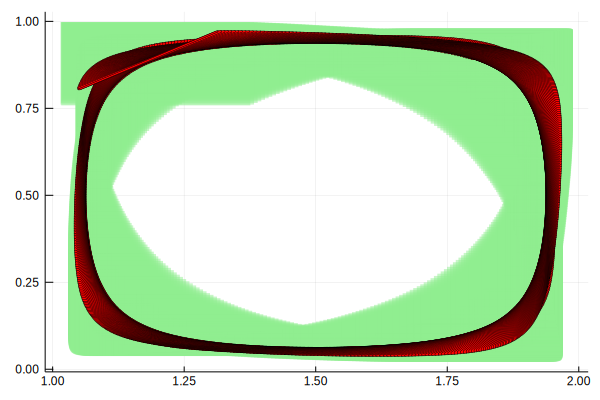

In [28]:
plot(sol[2][:], color=:lightgreen, lw=0.0, label="", alpha=.1)
plot!(z, lw=0.5, color=:red, alpha=1.0)